In [0]:
df = spark.sql("""
WITH ultimos_registros_dezembro_2023 AS (
    -- Consulta para trazer os registros de dezembro de 2023
    SELECT 
        v.site_sis, 
        MAX(v.quantidade_saldo_acumulado) AS quantidade_saldo_acumulado_dezembro
    FROM gold.vinculo_desvinculo_consolidado v
    JOIN gold.central c 
        ON v.site_sis = c.sistema
    WHERE v.data_referencia = current_date()-365 
        AND c.status = 'Ativo'
    GROUP BY v.site_sis
),
primeiros_registros_pos_dezembro AS (
    -- Consulta para trazer o primeiro registro após dezembro de 2023
    SELECT *
    FROM (
        SELECT
            v.site_sis,
            v.data_referencia AS primeira_data_pos_dezembro,
            v.quantidade_saldo_acumulado AS quantidade_saldo_acumulado_pos_dezembro,
            ROW_NUMBER() OVER (PARTITION BY v.site_sis ORDER BY v.data_referencia ASC) AS rn
        FROM gold.vinculo_desvinculo_consolidado v
        JOIN gold.central c 
            ON v.site_sis = c.sistema
        WHERE v.data_referencia > current_date()-365 
            AND c.status = 'Ativo'
            AND v.site_sis NOT IN (SELECT site_sis FROM ultimos_registros_dezembro_2023)
    ) subquery
    WHERE rn = 1
),
saldo_atual AS (
    -- Consulta para trazer o saldo atual de cada site_sis
    SELECT 
        c.sistema,
        SUM(v.quantidade_saldo) AS saldo_atual,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY v.quantidade_saldo_acumulado) AS mediana_saldo_acumulado
    FROM gold.vinculo_desvinculo_consolidado v
    JOIN gold.central c 
        ON v.site_sis = c.sistema
    WHERE c.status = 'Ativo'
    GROUP BY all
),
BLOQUEIOS as (SELECT
        c.sistema,
        count(id) as bloqueios
    FROM bronze.gdesk_action_events ae
    JOIN gold.central c ON ae.actionable_id = c.codigo_central
    WHERE ae.name = 'Bloquear Central' and ae.created_at >= '2023-09-01'
    group by all)

-- Combinar as consultas para trazer os resultados e comparar
SELECT 
    c.sistema,
    c.perfil,
    c.categoria_porte_empresa as porte,
    CASE 
        WHEN COALESCE(u.quantidade_saldo_acumulado_dezembro, p.quantidade_saldo_acumulado_pos_dezembro) IS NOT NULL 
        THEN LEAST(
            (COALESCE(s.saldo_atual, 0) - COALESCE(u.quantidade_saldo_acumulado_dezembro, p.quantidade_saldo_acumulado_pos_dezembro, 0)) 
            / COALESCE(u.quantidade_saldo_acumulado_dezembro, p.quantidade_saldo_acumulado_pos_dezembro, 0), 
            1
        )
        ELSE 0
    END AS variacao_base_perc,
    (SUM(CASE 
        WHEN e.estado_comunicando IN ('SEM COMUNICACAO','INDEFINIDO','COMUNICACAO INVALIDA') 
        THEN 1 ELSE 0 END) / NULLIF(COUNT(COALESCE(modulo, 0)), 0)) AS veic_sem_comunic_perc,
    COALESCE(bloqueios, 0) AS qtd_bloqueios,
    coalesce(f.perc_inadimplencia,0) as valor_devido_percentual
FROM gold.central c
left join silver.equipamento e on c.sistema = e.sistema
left join (select 
    sistema,
    sum(case when status_atualizado = 'Inadimplente' then valor else 0 end)/sum(valor) as perc_inadimplencia
    from gtk_dlk_prod.gold.financeiro_inadimplencia
    where data_vencimento > current_date()-365
    group by all) f on c.sistema = f.sistema
left join BLOQUEIOS ae on ae.sistema = c.sistema
left join saldo_atual s on s.sistema = c.sistema
LEFT JOIN ultimos_registros_dezembro_2023 u 
    ON s.sistema = u.site_sis
LEFT JOIN primeiros_registros_pos_dezembro p 
    ON s.sistema = p.site_sis
WHERE c.status = 'Ativo' and c.categoria_porte_empresa not in ('Nulo')
GROUP BY all
""")

In [0]:
df_pandas = df.toPandas()

In [0]:
df_pandas.head()

,sistema,perfil,porte,variacao_base_perc,veic_sem_comunic_perc,qtd_bloqueios,valor_devido_percentual
0,lcmrastreamento,REVENDA,Pequeno,0.565789,0.166994,4,0.099893
1,martinisat,RASTREAMENTO,Iniciante,0.000000,0.330275,8,0.000000
2,ps,RASTREAMENTO,Médio,-0.024306,0.271978,1,0.000000
3,taclog,RASTREAMENTO,Médio,-0.020902,0.744401,0,0.000000
4,mmttransportes,RASTREAMENTO,Iniciante,0.000000,0.000000,1,0.142552


In [0]:
df_pandas.describe().round(2)

,variacao_base_perc,veic_sem_comunic_perc,qtd_bloqueios,valor_devido_percentual
count,1154.00,1154.00,1154.00,1154.00
mean,0.22,0.42,1.15,0.04
std,0.46,0.25,2.54,0.09
min,-0.98,0.00,0.00,0.00
25%,-0.04,0.23,0.00,0.00
50%,0.08,0.38,0.00,0.00
75%,0.46,0.58,1.00,0.05
max,1.00,1.00,13.00,1.00


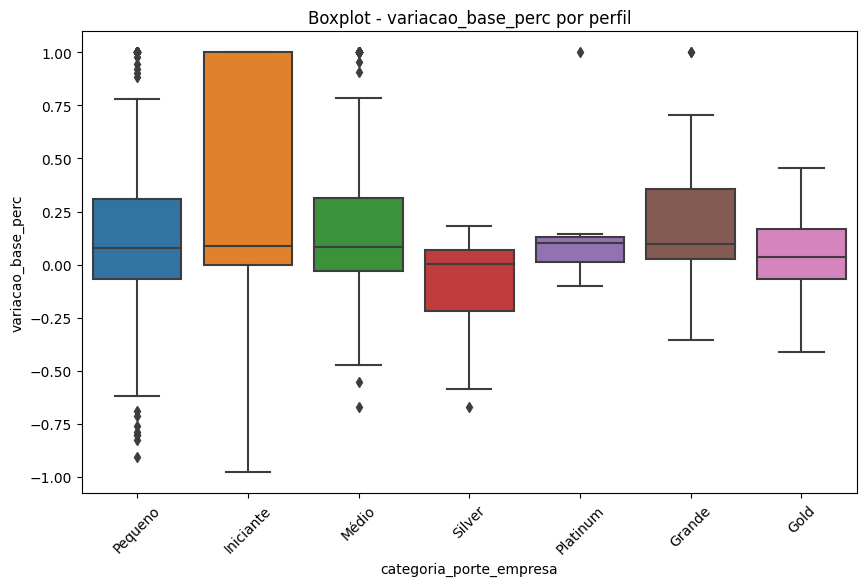

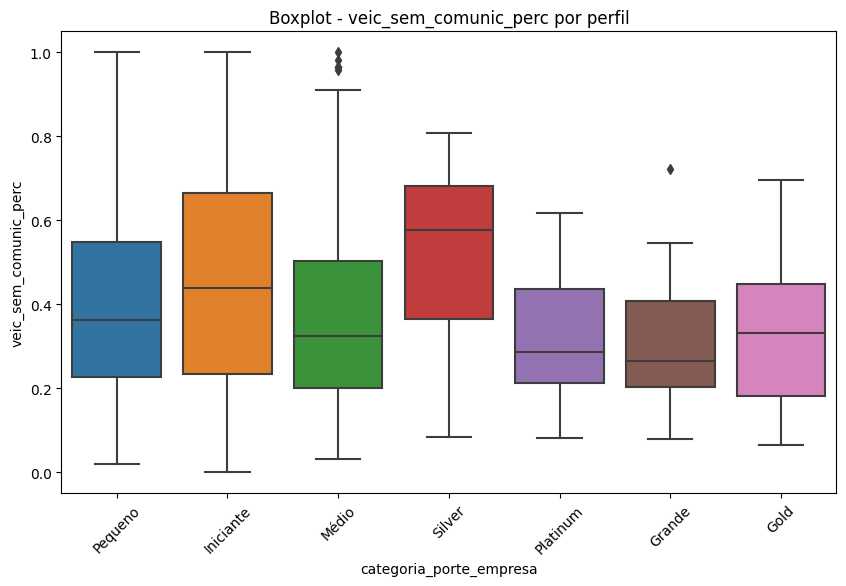

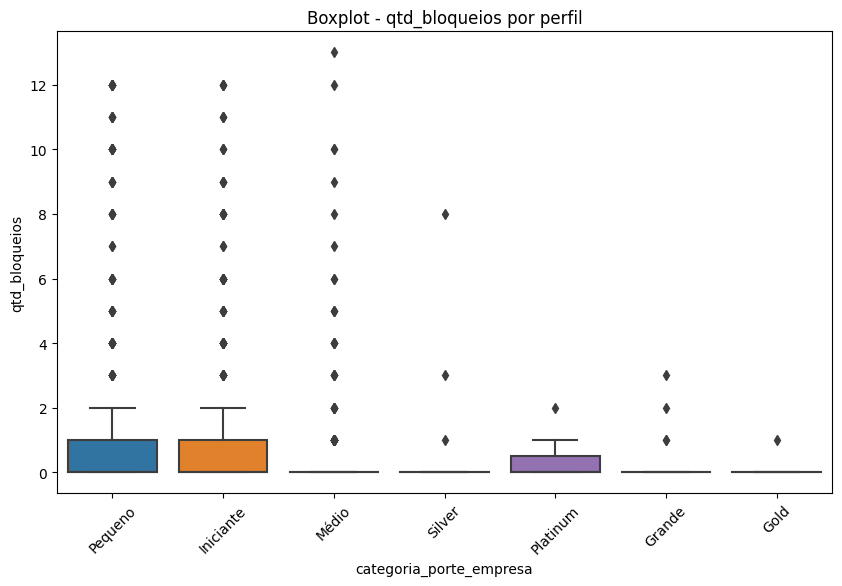

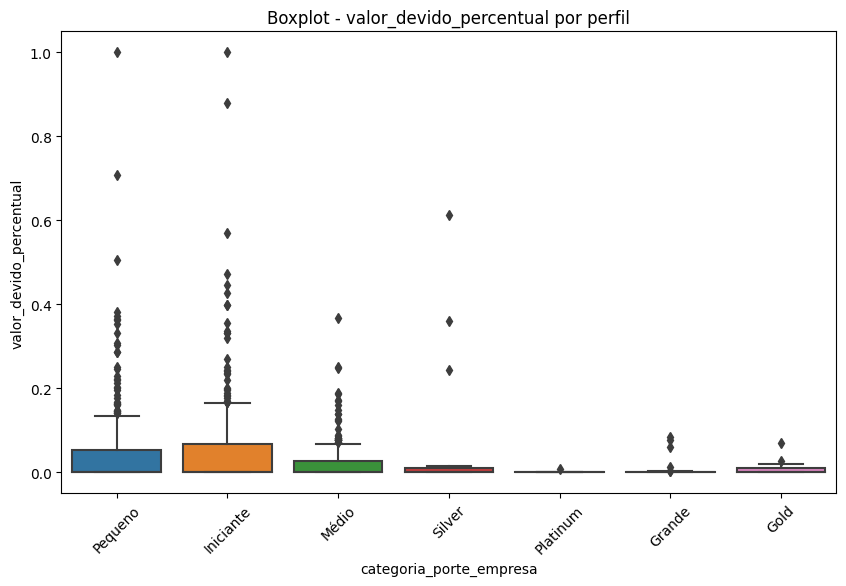

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de variáveis
variables = ['variacao_base_perc', 'veic_sem_comunic_perc', 'qtd_bloqueios', 'valor_devido_percentual']

# Verificar se a coluna 'perfil' existe no DataFrame
if 'porte' in df_pandas.columns:
    for variable in variables:
        if variable in df_pandas.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='porte', y=variable, data=df_pandas)
            plt.title(f'Boxplot - {variable} por perfil')
            plt.xlabel('categoria_porte_empresa')
            plt.ylabel(variable)
            plt.xticks(rotation=45)
            plt.show()
        else:
            print(f"Column '{variable}' does not exist in the DataFrame.")
else:
    print("A coluna 'porte' não existe no DataFrame.")


/home/spark-9d63a09b-0a00-400c-8255-19/.ipykernel/4448/command-2772041969681542-3905384219:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_pandas.corr()


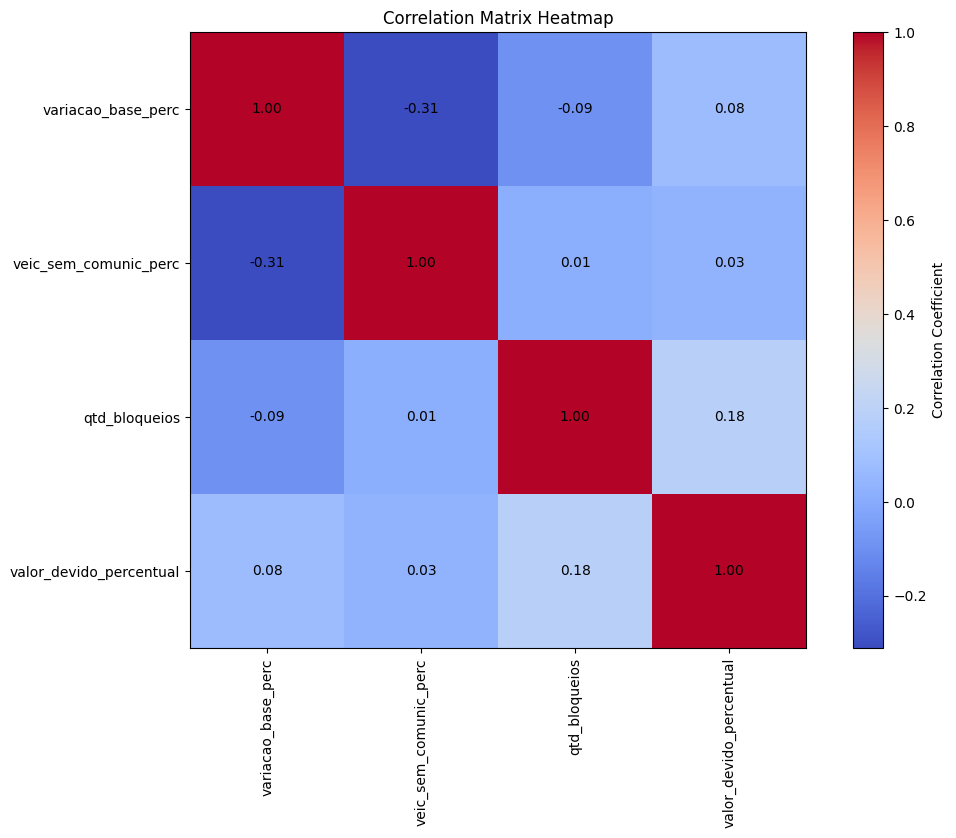

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponha que o df_pandas já esteja carregado com seus dados

# Gerar matriz de correlação
correlation_matrix = df_pandas.corr()

# Criar um gráfico de calor (heatmap) para a matriz de correlação
plt.figure(figsize=(12, 8))
heatmap = plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix Heatmap')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

# Adicionar rótulos de dados
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.show()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb984c09cf0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_ca

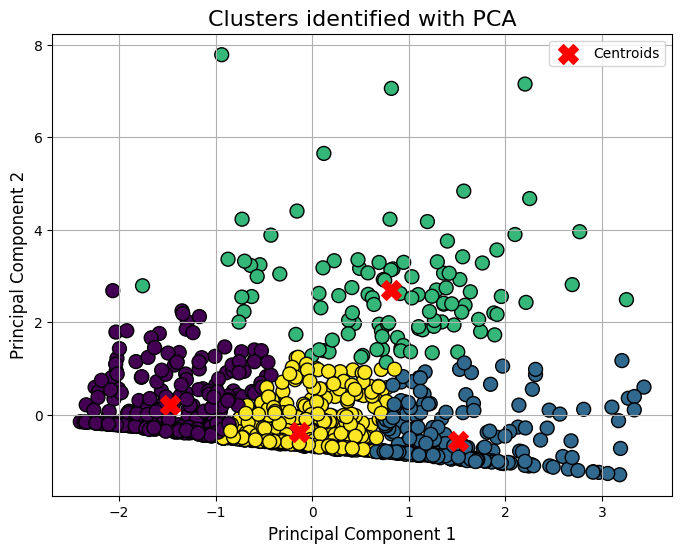

In [0]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # Import SimpleImputer
import matplotlib.pyplot as plt

# Assuming df_pandas is already loaded
colunas_para_pca = ['variacao_base_perc', 'veic_sem_comunic_perc', 'qtd_bloqueios', 'valor_devido_percentual']

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can change the strategy if needed
df_imputed = imputer.fit_transform(df_pandas[colunas_para_pca])

# Standardize the data
scaler = StandardScaler()
df_padronizado = scaler.fit_transform(df_imputed)

# Apply PCA to reduce to 2 principal components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_padronizado)

# Apply K-Means to identify clusters (adjust the number of clusters as needed)
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(pca_result)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', marker='o', s=100, edgecolor='k')
plt.title('Clusters identified with PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Add centroids to the plot
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.legend()
plt.grid(True)
plt.show()

In [0]:
# Obter os loadings (componentes principais)
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)], 
                        index=colunas_para_pca)

# Mostrar os loadings
print("Loadings (Componentes Principais):")
print(loadings)

Loadings (Componentes Principais):
                              PC1       PC2
variacao_base_perc      -0.696849  0.164623
veic_sem_comunic_perc    0.672642 -0.114423
qtd_bloqueios            0.245322  0.656642
valor_devido_percentual  0.042079  0.727068


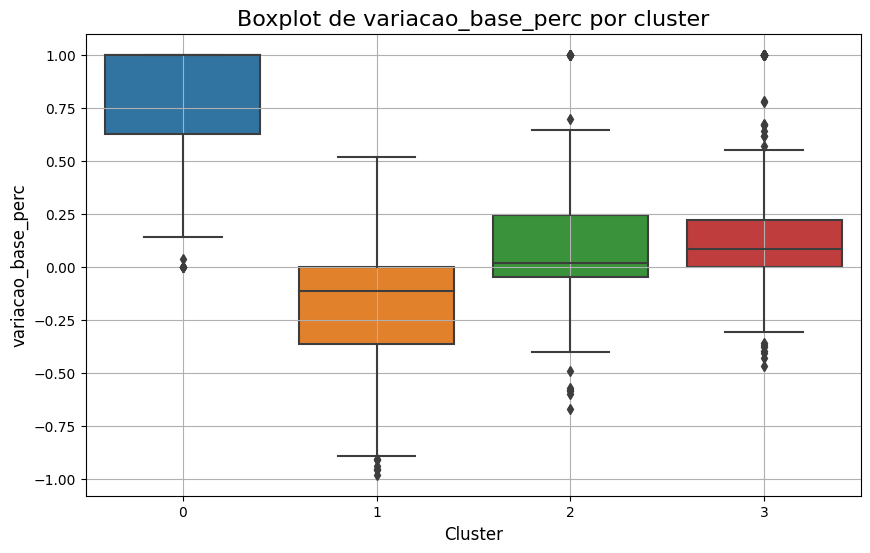

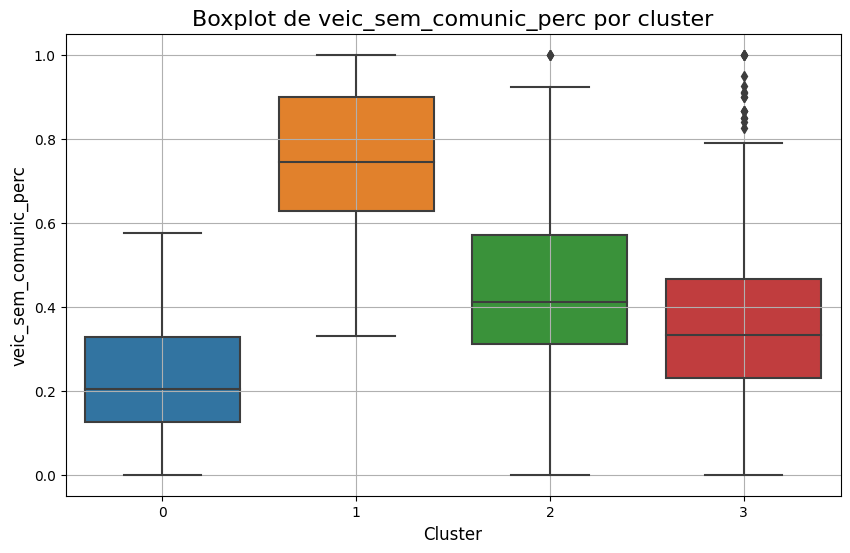

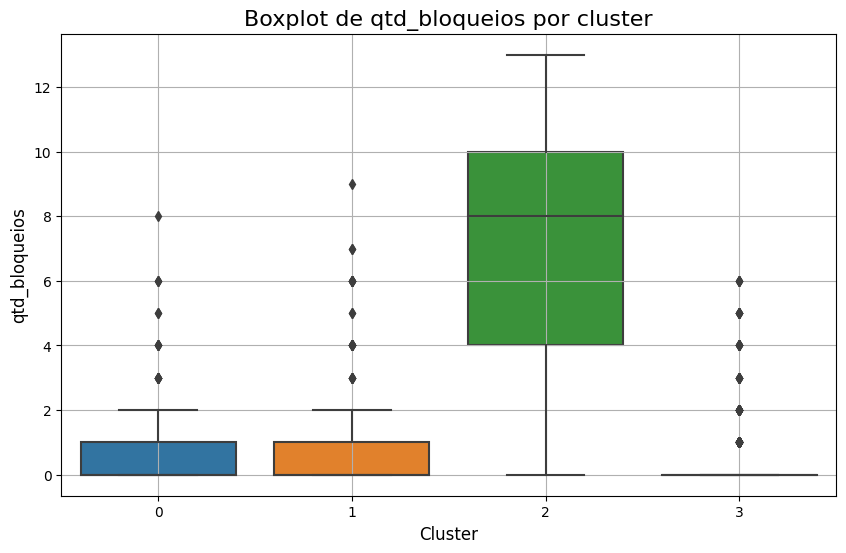

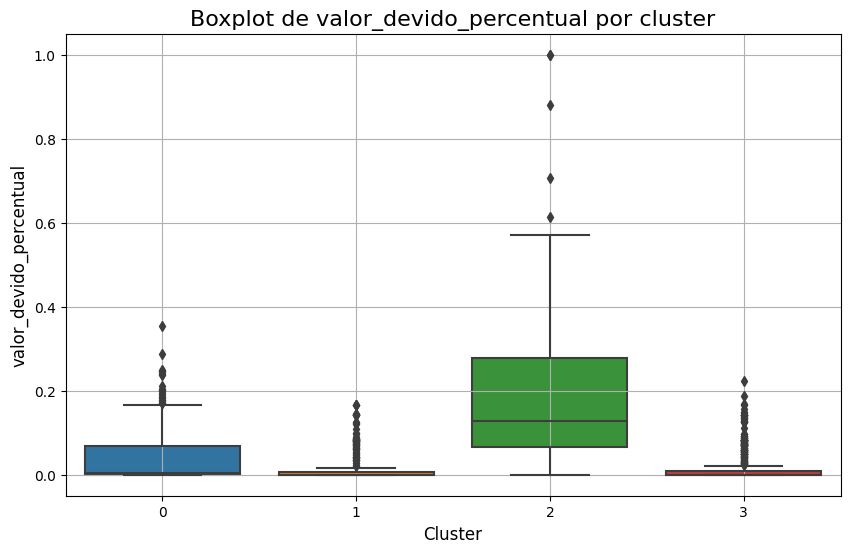

In [0]:
# Step 1: Adicionar os rótulos do cluster ao DataFrame original
df_pandas['cluster'] = clusters

# Step 2: Plotar o boxplot das variáveis por cluster
import seaborn as sns

# Plotar o boxplot para cada variável
for coluna in colunas_para_pca:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=coluna, data=df_pandas)
    plt.title(f'Boxplot de {coluna} por cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(coluna, fontsize=12)
    plt.grid(True)
    plt.show()


Tabela cruzada de percentuais para perfil:
cluster               0          1          2          3
perfil                                                  
ASSOCIACAO    17.777778  23.703704  14.074074  44.444444
CFTV          17.105263  28.947368   1.315789  52.631579
FROTA         29.090909  16.363636   1.818182  52.727273
RASTREAMENTO  24.514563  18.446602  10.315534  46.723301
REVENDA        4.687500  48.437500   1.562500  45.312500




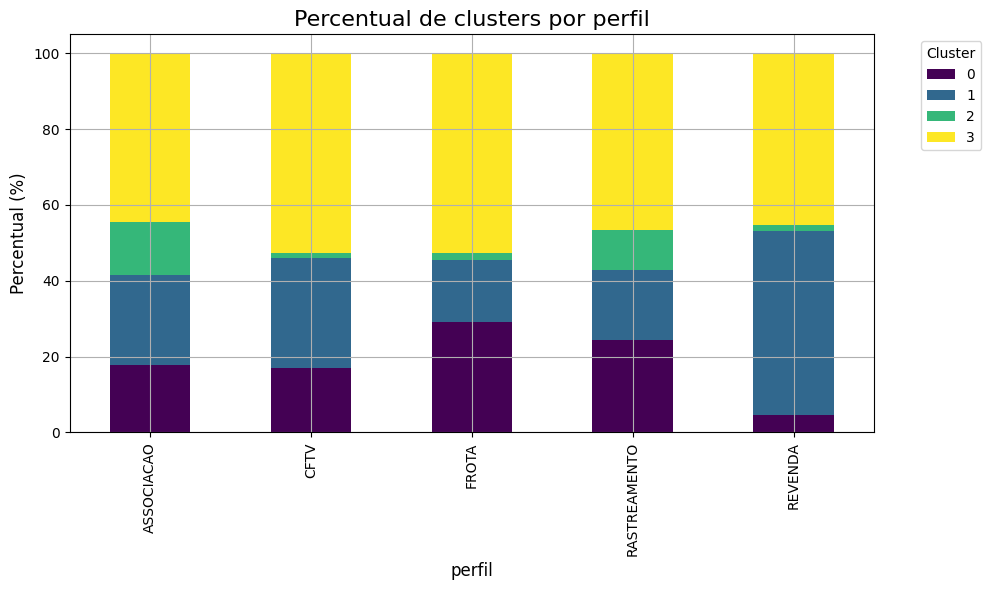

Tabela cruzada de percentuais para porte:
cluster            0          1          2          3
porte                                                
Gold       18.181818  18.181818   0.000000  63.636364
Grande     14.814815   0.000000   0.000000  85.185185
Iniciante  28.540773  23.819742   8.798283  38.841202
Médio      20.289855  18.357488   5.314010  56.038647
Pequeno    18.009479  21.090047  12.322275  48.578199
Platinum   14.285714  14.285714   0.000000  71.428571
Silver      0.000000  35.714286  21.428571  42.857143




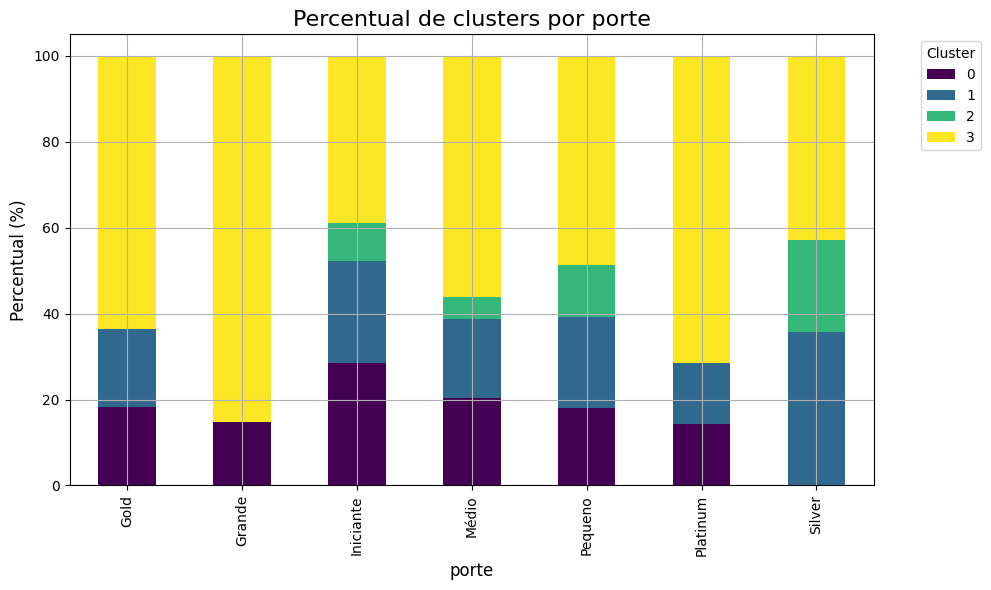

In [0]:
'   2134import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Verificar as variáveis categóricas
variaveis_categoricas = ['perfil', 'porte']  # Substitua pelas suas variáveis

# Step 2: Criar uma tabela cruzada mostrando a quantidade de clusters por cada variável categórica
for var in variaveis_categoricas:
    # Tabela cruzada normalizada (percentual por linha)
    crosstab_result = pd.crosstab(df_pandas[var], df_pandas['cluster'], normalize='index') * 100
    
    # Exibir a tabela de percentuais
    print(f'Tabela cruzada de percentuais para {var}:')
    print(crosstab_result)
    print('\n')

    # Plotar o gráfico de barras empilhadas em percentual
    crosstab_result.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='viridis')
    plt.title(f'Percentual de clusters por {var}', fontsize=16)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Percentual (%)', fontsize=12)
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legenda fora do gráfico
    plt.grid(True)
    plt.tight_layout()  # Ajustar o layout
    plt.show()